In [2]:
using Pkg
Pkg.activate("./Packages/Project.toml");

  Activating project at `c:\Users\HP\OneDrive\Documentos\julia\Heisenberg-Model-3D\Packages`


In [3]:
import Pkg
Pkg.add("Plots")

    Updating registry at `C:\Users\HP\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\HP\OneDrive\Documentos\julia\Heisenberg-Model-3D\Packages\Project.toml`
  No Changes to `C:\Users\HP\OneDrive\Documentos\julia\Heisenberg-Model-3D\Packages\Manifest.toml`


In [4]:
using LinearAlgebra
using Statistics
using Random
using Printf
using Plots

In [5]:
function RandomSpin()
    """Creates a random unit vector"""
    θ = rand(0:1e-6:π)
    ϕ = rand(0:1e-6:2π)
    return [sin(θ)*cos(ϕ), sin(θ)*sin(ϕ), cos(θ)]
end

function AcceptanceProbability(Spin1, Spin2, n, βJ)
    """Computes the probability of adding Spin2 - neighbour of
    Spin1 - to the cluster. It uses the energy βJ and the vector 
    of reflection n"""
    return 1 - exp(min(0,-2βJ*transpose(Spin1)*n*transpose(Spin2)*n))
end

function ReflectSpin(S,n,state)
    """Reflectes the spin state[S] around the plane defined by the
    normal vector n"""
    state[S] -=  2(transpose(state[S])*n)*n
end

function GetNeighbours(x,L,L2,L3)
    """Gets the coordinates of the 6 neighbour spins of the one in index x. It uses 
    periodic boundery conditions in a 3D lattice of length L (area L2, volume L3). 
    The matriz it returns contains the neighbours as folows: 
    [Up-Down-Left-Right-Front-Back]"""
    return [L2*((x-1)÷L2)+(x-1-L+L2)%L2+1,
            L2*((x-1)÷L2)+(x-1+L)%L2+1,
            L*((x-1)÷L)+(x+L-2)%L+1,
            L*((x-1)÷L)+(x)%L+1,
            (x-L2+L3-1)%L3+1,
            (x+L2-1)%L3+1]
end

function Grow_Reflect(S, Cluster, n, βJ, L, L2, L3, state)
    """Checks every neighbour of spin state[S] and adds them to the Cluster given
    a certain probability (See to AcceptanceProbability). Finally, it reflects
    the spin around the normal vector n (Refair to ReflectSpin)"""
    #Checks neighbours
    for Sn in GetNeighbours(S,L,L2,L3)
        if Sn ∉ Cluster && rand(0:1e-15:1) < AcceptanceProbability(state[S],state[Sn],n,βJ)
            #Adds neighbour to Cluster
            push!(Cluster,Sn)
            #Checks neighbours of neighbour
            Grow_Reflect(Sn, Cluster, n, βJ, L, L2, L3, state)
        end
    end
    #Reflects the spin
    ReflectSpin(S,n, state)
end

function NewState(state, L, L2, L3, βJ)
    """Chooses a randon spin from the state with lattice sice L, and also a
    random normal vector. From there it builds the cluster using Wolff algorithm
    (See Grow_Reflect)"""
    n = RandomSpin()     #Initial random Normal Vector
    #n = [0,0,1]         #Just for testing
    S0 = rand(1:1:L3)    #Initial random Spin
    Cluster = [S0]       #Stores the indexes of the spins added to the cluster
    Grow_Reflect(S0, Cluster, n, βJ, L, L2, L3, state) #Builds cluster and flips states for new state
    #print("The Cluster contains:  ",Cluster,"\n") #Just for testing
end;

In [6]:
function RandomIsing()
    """Creates spins only in the z-axis (testing only)"""
    return [0, 0, rand(-1.:2:1.)]
end;

In [9]:
function magnetization(state)
    """Returns the magnetization as the norm of the sum of all spins in the grid"""
    return norm(sum(state))
end;

In [32]:
function suceptibility(state)
    """Returns the msuceptibiliti as the variance of magnetizacion"""
    return norm(sum(state*transpose(state))) - norm(sum(state))^2
end;

In [45]:
function Proceed(βJ, epochs, jumps, L)
    """Creates a sequence of states and gets the magnetization once every fixed number 
    of epochs (i.e. jumps); finally, it returns the simple mean of all values obtained 
    this way. This is done for a single value of βJ in a lattice of size L."""
    L2 = L*L   #Lattice Area
    L3 = L*L2  #Lattice Volume
    #state = [RandomIsing() for i in 1:L3] #Just for testing
    state = [RandomSpin() for i in 1:L3]   #The 3D lattice is store as a 1D-Array
    #Random.seed!(51)
    M = []
    S = []
    for jj in 1:epochs
        NewState(state, L, L2, L3, βJ)
        if jj%jumps == 0
            push!(M,magnetization(state))
            push!(S,suceptibility(state))
        end
    end
    return mean(M), mean(M)
end;

In [72]:
Ms = [] #Stores magnetization for different tempetures
Ss = [] 
L = 10  #Lattice size
epochs = 80000   #Number of states generated
jumps = 1000     #Number of steps after which magnetization is calculated 
for kk in 1:30   #Loop over 30 different tempetures
    A, B = Proceed(.07*kk, epochs, jumps, L)
    #B = Proceed2(.07*kk, epochs, jumps, L)
    print("βJ=")
    @printf("%.2f",0.07*kk)
    print("--->", B,"\n")
    push!(Ms,A)
    push!(Ss,B)
end

βJ=0.07--->31.426634967034612
βJ=0.14--->34.005746369875354
βJ=0.21--->34.84787543397213
βJ=0.28--->40.814162540739126
βJ=0.35--->48.33921066438114
βJ=0.42--->51.364474895411355
βJ=0.49--->70.90829354472365
βJ=0.56--->96.47402410003545
βJ=0.63--->167.70816653366427
βJ=0.70--->351.01246480345276
βJ=0.77--->510.8645994915529
βJ=0.84--->600.4625819653198
βJ=0.91--->653.2364286557944
βJ=0.98--->688.0568337216407
βJ=1.05--->721.0013564474317
βJ=1.12--->744.3057130955297
βJ=1.19--->764.8188873462957
βJ=1.26--->780.0209228047744
βJ=1.33--->794.9967708947945
βJ=1.40--->806.5369466832768
βJ=1.47--->819.675463150066
βJ=1.54--->827.2227537828458
βJ=1.61--->836.4252809351947
βJ=1.68--->844.8646426812135
βJ=1.75--->852.14137923156
βJ=1.82--->858.7355998802466
βJ=1.89--->864.2676333585459
βJ=1.96--->870.6830739920526
βJ=2.03--->875.3715417632171
βJ=2.10--->880.426313464731


In [73]:
T = [1/(.07*m) for m in 1:30];
#Ms = [34.28208919364256,34.745138286478046,38.26800596874746,41.09790735611848,47.4360176604439,59.36892070175056,71.92355443935362,86.45898883692931,140.5417491675026,366.2136816692767,516.0546491379607,597.1829646015005,651.7745418779497,689.8671854925656,720.6774146326808,745.1965470366077,765.6582880990809,780.2933910416982,793.044282921708,806.2858551668758,820.9773801117806,828.5002005933918,836.5632828278818,844.4264263955017,851.7334067701831,858.6795778805848,865.5924709106112,869.9807167714749,874.0731951074237,879.6652289039079]

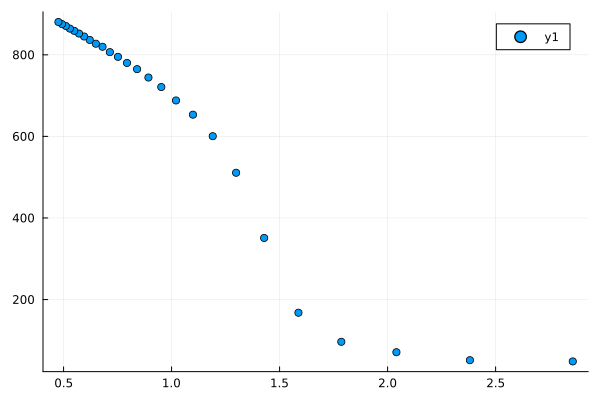

In [74]:
plot(T[5:30],Ms[5:30],seriestype = :scatter) # M vs T

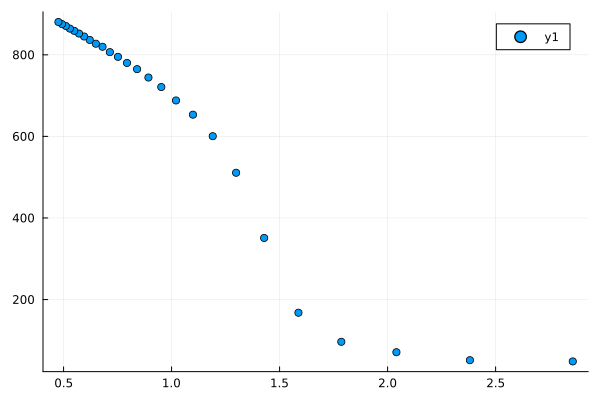

In [77]:
plot(T[5:30],Ss[5:30],seriestype = :scatter) # M vs T